In [23]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy, BatchNorm
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

In [24]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [68]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST(split=:train)[:]
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder, W3, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder), W3 = cpu(W3)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder W3
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))
    
    decoder = Chain(
        Dense(20, 500, relu, bias = false),
        Dense(500,500, relu,bias = false),
    )

    W3 = randn(784,500)
    return encoder_μ, encoder_logvar, decoder, W3
end

create_vae (generic function with 1 method)

In [69]:
function vae_loss(encoder_μ, encoder_logvar, decoder, W3, x, β, λ, F)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample

    scaled_sig(x) = sigmoid(x/10)
    x̂ = scaled_sig(W3*decoder(z))

    loss_α(F,A) = maximum(sqrt.(sum((F*A).*(F*A), dims = 2))) + 100*norm(A'*A - I(500),2)^2

    α = loss_α(F, W3)
    
    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(binarycrossentropy.(x̂, x)) 
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, decoder, W3))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg + 10000 * α 
end

function train(encoder_μ, encoder_logvar, decoder, W3, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder, W3)
    progress_tracker = Progress(num_epochs, "Training a epoch done")
    F = dct(diagm(ones(784)),2);

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            # x_batch[x_batch .> .8] .= .8; x_batch[x_batch .< .2]  .= .2

            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, W3, x_batch, β, λ, F)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, W3, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [70]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 40
save_dir = "test/trained_GNN/MNIST_sigmoid_v2"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
encoder_μ, encoder_logvar, decoder, W3 = create_vae()
train(encoder_μ, encoder_logvar, decoder, W3, dataloader, num_epochs, λ, β, ADAM(η), save_dir)



Saving model...Done


Training a epoch done   5%|█▌                            |  ETA: 1:54:07


Saving model...Done



Training a epoch done   8%|██▎                           |  ETA: 1:53:07


Saving model...Done



Training a epoch done  10%|███                           |  ETA: 1:51:19


Saving model...Done


Training a epoch done  12%|███▊                          |  ETA: 1:48:58


Saving model...Done



Training a epoch done  15%|████▌                         |  ETA: 1:45:57


Saving model...Done



Training a epoch done  18%|█████▎                        |  ETA: 1:42:55


Saving model...Done


Training a epoch done  20%|██████                        |  ETA: 1:39:44


Saving model...Done


Training a epoch done  22%|██████▊                       |  ETA: 1:36:32


Saving model...Done



Training a epoch done  25%|███████▌                      |  ETA: 1:33:27


Saving model...Done



Training a epoch done  28%|████████▎                     |  ETA: 1:30:39


Saving model...Done



Training a epoch done  30%|█████████                     |  ETA: 1:27:52


Saving model...Done



Training a epoch done  32%|█████████▊                    |  ETA: 1:25:04


Saving model...Done



Training a epoch done  35%|██████████▌                   |  ETA: 1:22:20


Saving model...Done


Training a epoch done  38%|███████████▎                  |  ETA: 1:19:34


Saving model...Done


Training a epoch done  40%|████████████                  |  ETA: 1:16:36


Saving model...Done


Training a epoch done  42%|████████████▊                 |  ETA: 1:13:30


Saving model...Done


Training a epoch done  45%|█████████████▌                |  ETA: 1:10:23


Saving model...Done



Training a epoch done  48%|██████████████▎               |  ETA: 1:07:19


Saving model...Done


Training a epoch done  50%|███████████████               |  ETA: 1:04:14


Saving model...Done



Training a epoch done  52%|███████████████▊              |  ETA: 1:01:08


Saving model...Done



Training a epoch done  55%|████████████████▌             |  ETA: 0:58:00


Saving model...Done



Training a epoch done  58%|█████████████████▎            |  ETA: 0:54:47


Saving model...Done



Training a epoch done  60%|██████████████████            |  ETA: 0:51:31


Saving model...Done



Training a epoch done  62%|██████████████████▊           |  ETA: 0:48:15


Saving model...Done


Training a epoch done  65%|███████████████████▌          |  ETA: 0:44:59


Saving model...Done



Training a epoch done  68%|████████████████████▎         |  ETA: 0:41:43


Saving model...Done



Training a epoch done  70%|█████████████████████         |  ETA: 0:38:26


Saving model...Done



Training a epoch done  72%|█████████████████████▊        |  ETA: 0:35:11


Saving model...Done



Training a epoch done  75%|██████████████████████▌       |  ETA: 0:31:57


Saving model...Done



Training a epoch done  78%|███████████████████████▎      |  ETA: 0:28:44


Saving model...Done


Training a epoch done  80%|████████████████████████      |  ETA: 0:25:40


Saving model...Done



Training a epoch done  82%|████████████████████████▊     |  ETA: 0:22:36


Saving model...Done



Training a epoch done  85%|█████████████████████████▌    |  ETA: 0:19:20


Saving model...Done


Training a epoch done  88%|██████████████████████████▎   |  ETA: 0:16:05


Saving model...Done



Training a epoch done  90%|███████████████████████████   |  ETA: 0:12:50


Saving model...Done



Training a epoch done  92%|███████████████████████████▊  |  ETA: 0:09:37


Saving model...Done


Training a epoch done  95%|████████████████████████████▌ |  ETA: 0:06:24


Saving model...Done



Training a epoch done  98%|█████████████████████████████▎|  ETA: 0:03:11


Saving model...Done



Training a epoch done 100%|██████████████████████████████| Time: 2:07:26
  loss:  16850.80005229786


Saving model...Done
Training complete!


In [29]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST(split=:test)[:]
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, W3, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample

    x̂ = sigmoid(W3*decoder(z))
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder W3
    println("Done")
    return encoder_μ, encoder_logvar, decoder, W3
end

function visualise()
    # Define some parameters
    batch_size = 1
    shuffle = true
    num_images = 1
    epoch_to_load = 20
    # Load the model and test set loader
    dir = "test/trained_GNN/MNIST_sigmoid_inco"
    encoder_μ, encoder_logvar, decoder, W3 = load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, W3, x_batch)
        print(size(x_batch))
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [162]:
visualise()

Loading model...Done


(784, 1)

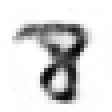

In [157]:
load("test/trained_GNN/MNIST_sigmoid_inco/reconstruction-1.png")

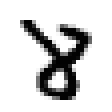

In [158]:
load("test/trained_GNN/MNIST_sigmoid_inco/test-image-1.png")

All function imported
Loading model...Done

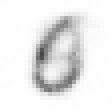

In [63]:
using NBInclude
@nbinclude("src/functions.ipynb")
epoch_to_load =40
# Load the model and test set loader
dir = "test/trained_GNN/MNIST_sigmoid_inco"
encoder_μ, encoder_logvar, decoder, W3 = load_model_identity(dir, epoch_to_load);


batch_size = 64; shuffle = true
dataloader = get_test_loader(batch_size, shuffle)
(x_batch, y_batch) = first(dataloader)

# x = reshape(x_batch[:,1], 784,1)

μ = encoder_μ(x_batch)
logvar = encoder_logvar(x_batch)
# Apply reparameterisation trick to sample latent
z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar);

colorview(Gray,reshape(sigmoid(W3*decoder(z))[:,1], 28,28)')






In [47]:
z[:,1]

20-element Vector{Float32}:
 -0.8121152
  1.1989852
  0.9215686
 -0.9055035
 -0.90005434
 -0.8444268
  0.41006792
 -0.9674509
  2.484702
 -0.64016926
 -1.6264142
  1.0884744
  0.5414382
  2.6425004
 -0.9559748
 -0.6307085
 -0.3940503
  0.97894895
  0.07229303
  0.65780807